# Cheminformatics Project: 
## _Predicting aqueous solubility for a range of different compounds_
#### Contents: 
1. Data Collection
1. Data Preparation
1. Exploratory Data Analysis

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import ceil
import gzip

from rdkit import Chem
from rdkit.Chem import PandasTools, Descriptors, rdMolDescriptors

import sklearn.metrics
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

color_palette = sns.color_palette(palette='coolwarm')
sns.set(style='ticks', context="paper", palette=color_palette)

In [3]:
np.random.seed(0)

## Data Collection and Processing
---

In [132]:
df = pd.read_csv('delaney-processed.csv')
# dropping the mol weight, min degree, h bond donors, rings, rotatable bonds, polar surface area measurements to better recreate Delaneys resutls: 
df = df.drop(columns=['Polar Surface Area', 'Number of Rotatable Bonds', 'Number of H-Bond Donors', 'Molecular Weight', 'Minimum Degree', 'Number of Rings'])
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,-1.33,c1ccsc1


Adding the molecule to the dataframe using the smiles column.

In [133]:
PandasTools.AddMoleculeColumnToFrame(df, 'smiles', 'Molecule')

Cleaning the titles of the columns to give them better units:

In [134]:
df.rename(columns={'Compound ID':'Name', 'smiles' : 'SMILES',
                   'ESOL predicted log solubility in mols per litre' : 'ESOL Predicted log(solubility/M)',
                   'measured log solubility in mols per litre' : 'Measured log(solubility/M)'})

,Name,ESOL Predicted log(solubility/M),Measured log(solubility/M),SMILES,Molecule
0,Amigdalin,-0.974,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x28dc2b300>
1,Fenfuram,-2.885,-3.300,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x28dc2b0d0>
2,citral,-2.579,-2.060,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x28dc2aea0>
3,Picene,-6.618,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x28dc29af0>
4,Thiophene,-2.232,-1.330,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x28dc29a10>
...,...,...,...,...,...
1123,halothane,-2.608,-1.710,FC(F)(F)C(Cl)Br,<rdkit.Chem.rdchem.Mol object at 0x28d0c20a0>
1124,Oxamyl,-0.908,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x28d0c2110>
1125,Thiometon,-3.323,-3.091,CCSCCSP(=S)(OC)OC,<rdkit.Chem.rdchem.Mol object at 0x28d0c2180>
1126,2-Methylbutane,-2.245,-3.180,CCC(C)C,<rdkit.Chem.rdchem.Mol object at 0x28d0c21f0>


In [135]:
df.head(5)

,Compound ID,ESOL predicted log solubility in mols per litre,measured log solubility in mols per litre,smiles,Molecule
0,Amigdalin,-0.974,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x28dc2b300>
1,Fenfuram,-2.885,-3.30,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x28dc2b0d0>
2,citral,-2.579,-2.06,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x28dc2aea0>
3,Picene,-6.618,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x28dc29af0>
4,Thiophene,-2.232,-1.33,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x28dc29a10>


In [5]:
# we can now use RDKit to generate some decsriptive features using the smiles of each compound,
# but first a helper method to get the descriptors directly from smiles, we can then query the exact property we want off the molecule. 
def calc_descriptors_from_smiles(mol): 
    return Descriptors.CalcMolDescriptors(mol) 

# getting more specific features from the descriptors, including proportion of aromatic atoms, number of rotatable bonds, octanol-water partition coefficient
# molecular weight, H bond acceptors and number of heteroatoms
def molec_weight(mol): # calculating the molecular weight
    return calc_descriptors_from_smiles(mol)['MolWt']

def aromatic_atom_proportion(mol): # calculating the proportion of aromatic atoms
    no_atoms = mol.GetNumAtoms()
    aromatic_atoms = [mol.GetAtomWithIdx(i).GetIsAromatic() for i in range(no_atoms)] #returns true/false for each atom
    aromatic_count = sum(aromatic_atoms)
    proportion = aromatic_count / no_atoms
    return proportion

def mol_logP(mol): # calculating the octanol-water partition coefficient
    return calc_descriptors_from_smiles(mol)['MolLogP']

def non_carbon_proportion(mol): 
    no_atoms = mol.GetNumAtoms()
    patt = Chem.MolFromSmarts('[C]')
    carbon_count = sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 6)
    non_carbon_count = no_atoms - carbon_count
    return non_carbon_count / no_atoms

def no_H_bond_acceptors(mol): # calculating the number of hydrogen bond acceptors
    return calc_descriptors_from_smiles(mol)['NumHAcceptors']

def no_H_bond_donors(mol): # calculating the number of hydrogen bond donors
    return calc_descriptors_from_smiles(mol)['NumHDonors']

def polar_surface_area(mol): 
    return calc_descriptors_from_smiles(mol)['TPSA']

def no_aromatic_rings(mol): # calculating the number of aromatic rings
    return calc_descriptors_from_smiles(mol)['NumAromaticRings']

def heteroatom_proportion(mol): # calculating the proportion of heteroatoms
    no_atoms = mol.GetNumAtoms()
    heteroatom_count = Descriptors.CalcMolDescriptors(mol)['NumHeteroatoms']
    proportion = heteroatom_count / no_atoms
    return proportion

def rot_bonds(mol): # calculate the number of rotatable bonds
    return calc_descriptors_from_smiles(mol)['NumRotatableBonds']

Adding these new columns to the dataframe to replicate the dataset used by Delaney:  

In [137]:
df['MW'] = df['Molecule'].apply(molec_weight)
df['log(P/mol)'] = df['Molecule'].apply(mol_logP)
df['Number of Rotatable Bonds'] = df['Molecule'].apply(rot_bonds)
df['Proportion of Aromatic atoms'] = df['Molecule'].apply(aromatic_atom_proportion)
df['Proportion of Non Carbon atoms'] = df['Molecule'].apply(non_carbon_proportion)
df['Polar Surface Area'] = df['Molecule'].apply(polar_surface_area)
df['Number of H Bond Donors'] = df['Molecule'].apply(no_H_bond_donors)
df['Number of H Bond Acceptors'] = df['Molecule'].apply(no_H_bond_acceptors)

In [138]:
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,measured log solubility in mols per litre,smiles,Molecule,MW,log(P/mol),Number of Rotatable Bonds,Proportion of Aromatic atoms,Proportion of Non Carbon atoms,Polar Surface Area,Number of H Bond Donors,Number of H Bond Acceptors
0,Amigdalin,-0.974,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x28dc2b300>,457.432,-3.10802,7,0.187500,0.375000,202.32,7,12
1,Fenfuram,-2.885,-3.30,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x28dc2b0d0>,201.225,2.84032,2,0.733333,0.200000,42.24,1,2
2,citral,-2.579,-2.06,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x28dc2aea0>,152.237,2.87800,4,0.000000,0.090909,17.07,0,1
3,Picene,-6.618,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x28dc29af0>,278.354,6.29940,0,1.000000,0.000000,0.00,0,0
4,Thiophene,-2.232,-1.33,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x28dc29a10>,84.143,1.74810,0,1.000000,0.200000,0.00,0,1


We have all of the data required to replicate Delaney's results. We will save this to a new csv:

In [139]:
df.to_csv('delaney-processed-baseline.csv')

## Data Analysis
----
Beginning with some exploratory data analysis so we can see what we are dealing with:

In [16]:
baseline_df = pd.read_csv('delaney-processed-baseline.csv')
baseline_df = baseline_df.drop(columns='Unnamed: 0', axis=1)
baseline_df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,measured log solubility in mols per litre,smiles,Molecule,MW,log(P/mol),Number of Rotatable Bonds,Proportion of Aromatic atoms,Proportion of Non Carbon atoms,Polar Surface Area,Number of H Bond Donors,Number of H Bond Acceptors
0,Amigdalin,-0.974,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x28dc2b300>,457.432,-3.10802,7,0.187500,0.375000,202.32,7,12
1,Fenfuram,-2.885,-3.30,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x28dc2b0d0>,201.225,2.84032,2,0.733333,0.200000,42.24,1,2
2,citral,-2.579,-2.06,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x28dc2aea0>,152.237,2.87800,4,0.000000,0.090909,17.07,0,1
3,Picene,-6.618,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x28dc29af0>,278.354,6.29940,0,1.000000,0.000000,0.00,0,0
4,Thiophene,-2.232,-1.33,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x28dc29a10>,84.143,1.74810,0,1.000000,0.200000,0.00,0,1


In [17]:
baseline_df.describe()
baseline_data_vis_df = baseline_df.drop(['Molecule', 'smiles', 'Compound ID'], axis=1)

### Data Visualisations
----
Aiming to display the distributions of the various different data categories, and any correlations we can expect to begin with. For the data that is non-continuous we will use bar plots in 1D and swarm plots in 2D, for the continuous data we will use histograms in 1D and scatter plots in 2D.

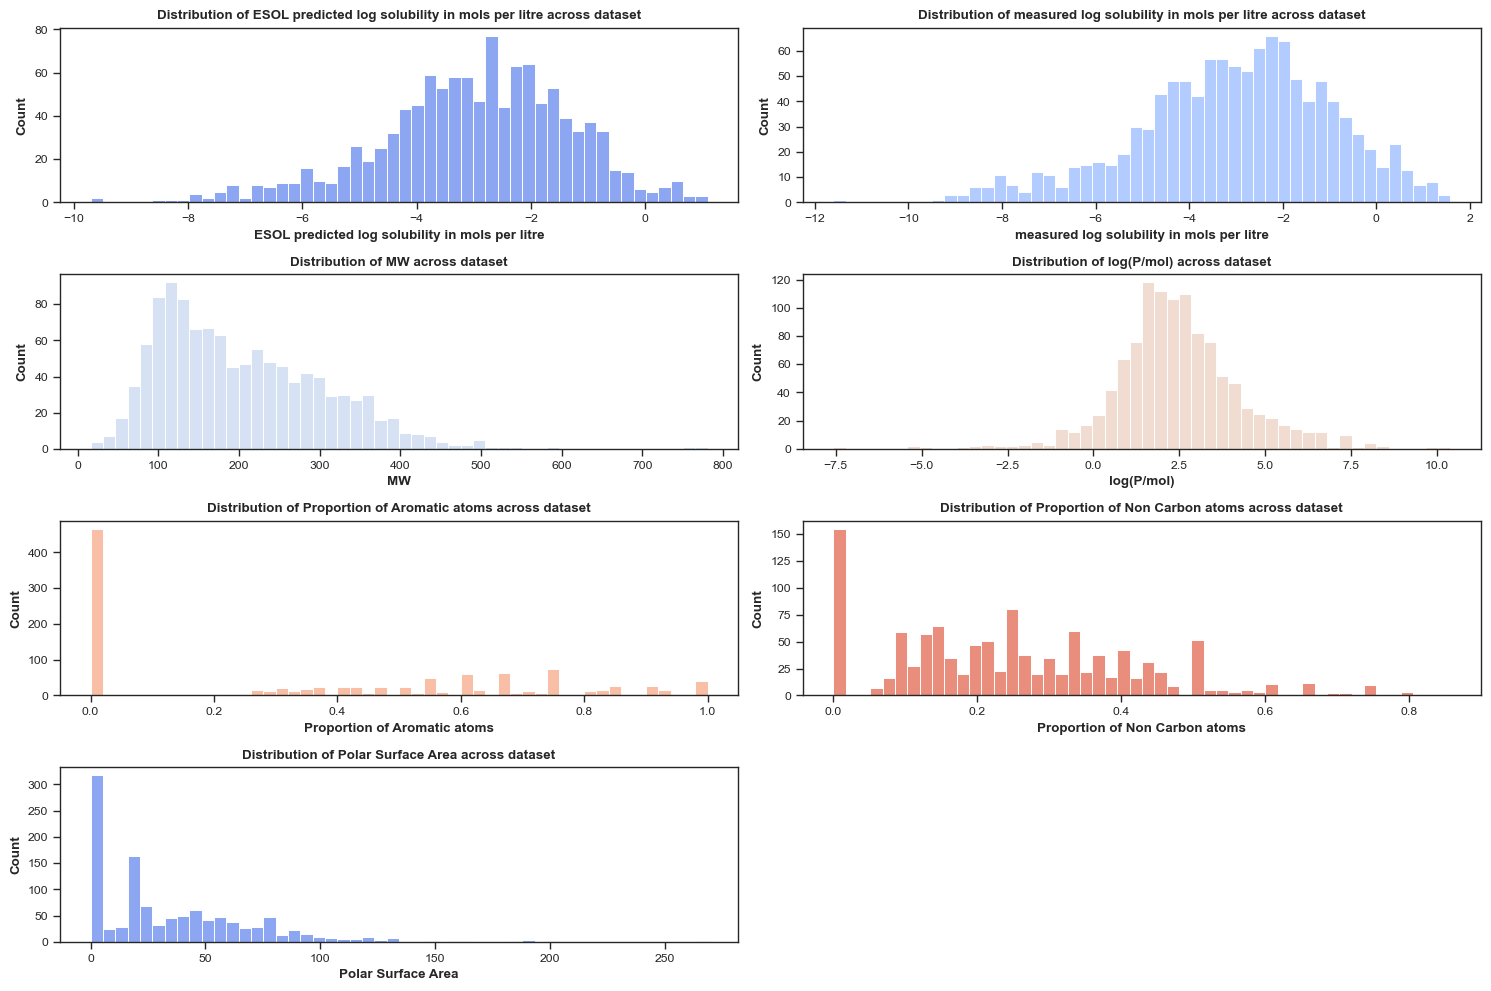

In [18]:
# beginning with the data distribution visualisations: 
ncols, nrows = 2, 4
cont_features = [col for col in list(baseline_data_vis_df.columns) if col != 'Number of H Bond Donors' and col != 'Number of H Bond Acceptors'
                and col != 'Number of Rotatable Bonds']
non_cont_features = ['Number of H Bond Donors', 'Number of H Bond Acceptors', 'Number of Rotatable Bonds']
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
for index, feature in enumerate(cont_features):
    if index >= nrows * ncols:
        break  # Exit the loop if we've plotted all available subplots
    i = index // ncols
    j = index % ncols
    
    # Use the color from the palette based on the index
    color = color_palette[index % len(color_palette)]

    sns.histplot(baseline_df[feature], ax=axs[i, j], bins=50, color=color)
    axs[i,j].set_title('Distribution of ' + feature + ' across dataset', fontweight='bold')
    axs[i,j].set_ylabel('Count', fontweight='bold')
    axs[i,j].set_xlabel(str(feature), fontweight='bold')

# Hiding any empty subplots if there are more subplots than features
for i in range(len(cont_features), nrows * ncols):
    axs[i // ncols, i % ncols].axis('off')

plt.tight_layout()
plt.show()

The key points from this being that there are many molecules with 0 aromatic/non carbon atoms and polar surface area. These 3 features are fairly evenly distributed, with polar surface area being slightly skewed towards zero. The rest follow a (roughly) gaussian distribution. 

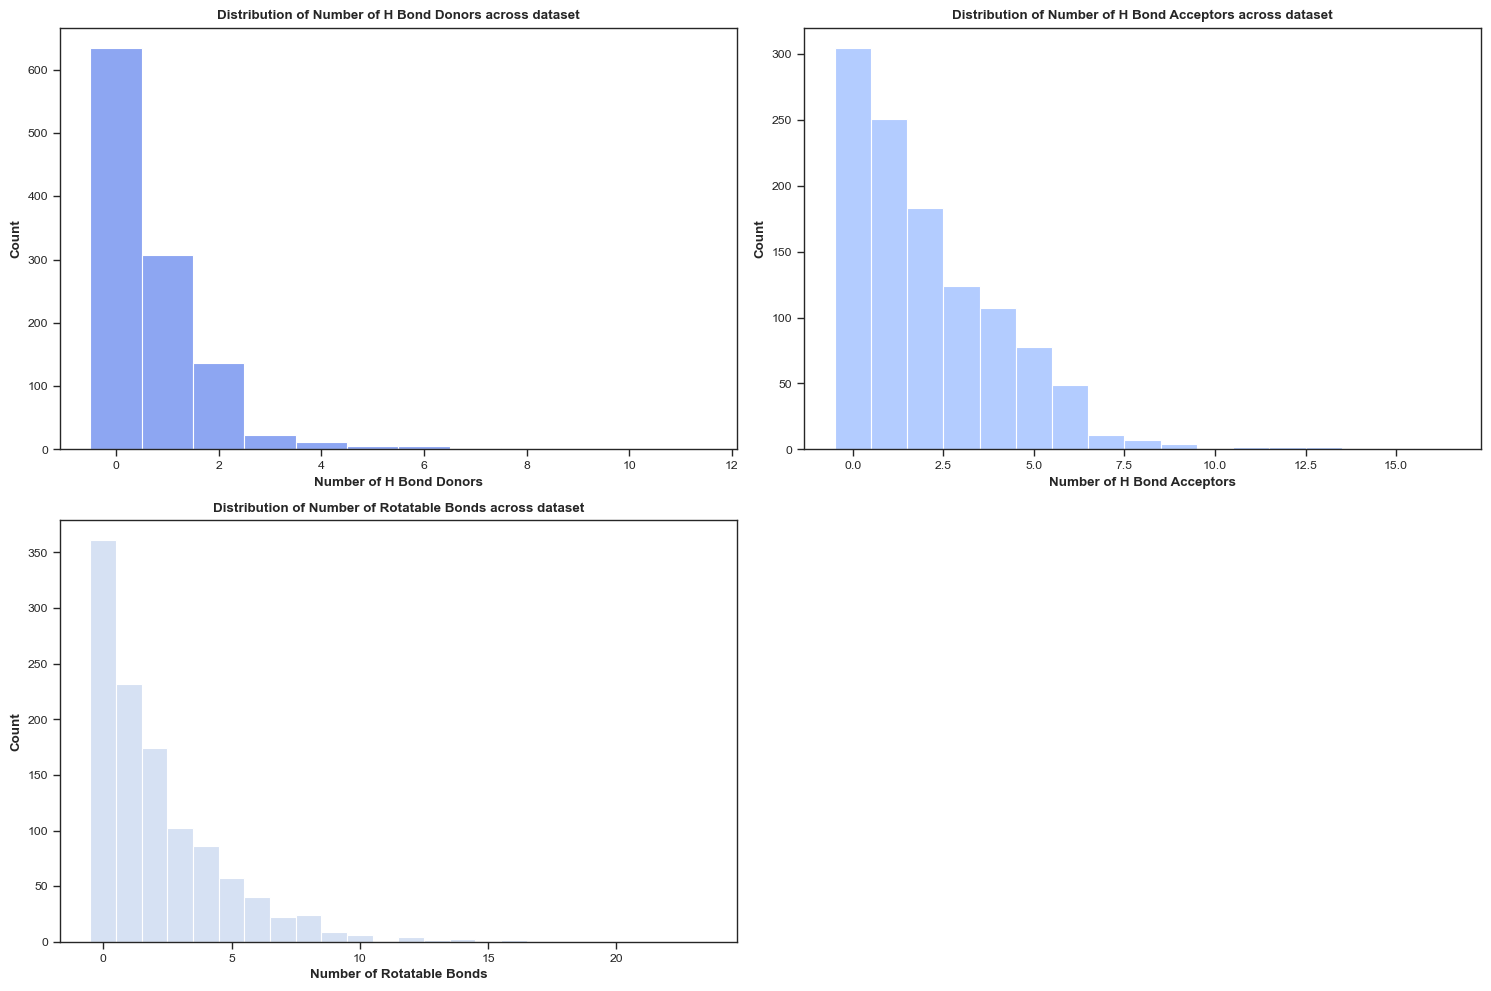

In [19]:
ncols = 2
nrows = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,10))
for index, feature in enumerate(non_cont_features):
    if index >= nrows * ncols:
        break  # Exit the loop if we've plotted all available subplots
    i = index // ncols
    j = index % ncols
    
    # Use the color from the palette based on the index
    color = color_palette[index % len(color_palette)]

    sns.histplot(baseline_df[feature], ax=axs[i, j], bins=50, discrete=True, color=color)
    axs[i,j].set_title('Distribution of ' + feature + ' across dataset', fontweight='bold')
    axs[i,j].set_ylabel('Count', fontweight='bold')
    axs[i,j].set_xlabel(str(feature), fontweight='bold')

# Hiding any empty subplots if there are more subplots than features
for i in range(len(non_cont_features), nrows * ncols):
    axs[i // ncols, i % ncols].axis('off')

plt.tight_layout()
plt.show()

The data skews heavily towards molecules with fewer H Bond Donors/Acceptors/Rotatable Bonds


----
### 2D Visualisations:
----
Since we are interested in the factors that contribute to the solubility of the compounds we will plot these against the measured log solubility to determine the level of correlation between certain varaibles.

In [20]:
comparison_cont_feature = cont_features.pop(1) # removing the measured log solubility of the compound. 

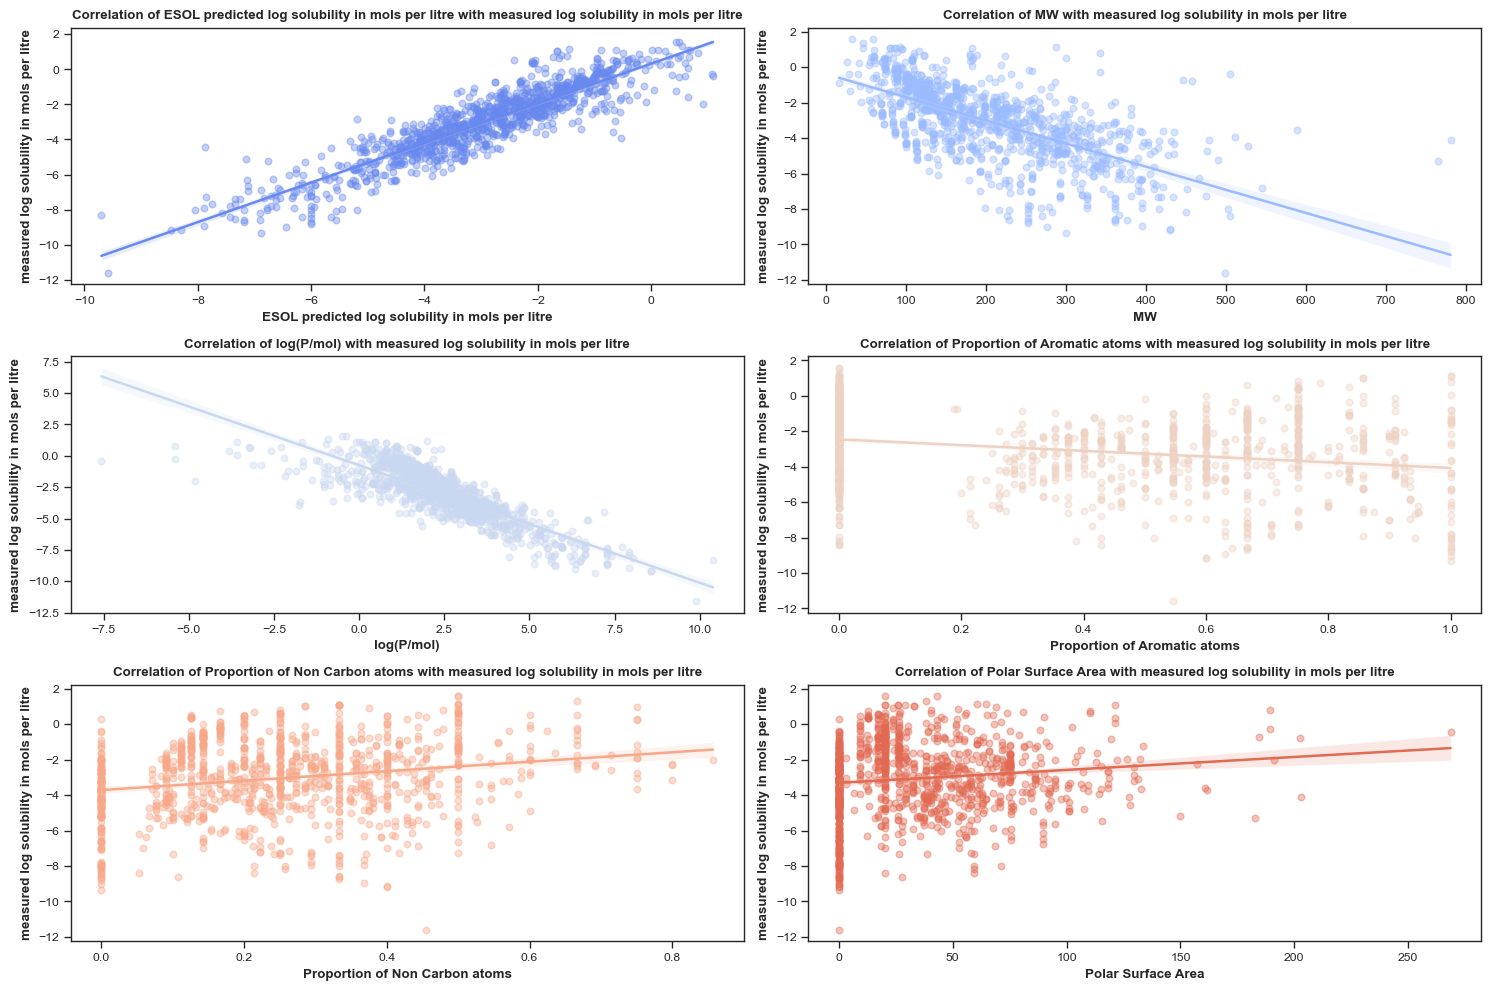

In [21]:
nrows = 3
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for index, feature in enumerate(cont_features):
    if index >= nrows * ncols:
        break  # Exit the loop if we've plotted all available subplots
    i = index // ncols
    j = index % ncols
    
    # Use the color from the palette based on the index
    color = color_palette[index % len(color_palette)]
    
    sns.regplot(x=baseline_df[feature], y=baseline_df[comparison_cont_feature], ax=axs[i, j], scatter_kws={'alpha': 0.4}, color=color)
    axs[i, j].set_title('Correlation of ' + feature + ' with ' + comparison_cont_feature, fontweight='bold')
    axs[i, j].set_ylabel(str(comparison_cont_feature), fontweight='bold')
    axs[i, j].set_xlabel(str(feature), fontweight='bold')

# Hiding any empty subplots if there are more subplots than features
for i in range(len(cont_features), nrows * ncols):
    axs[i // ncols, i % ncols].axis('off')

plt.tight_layout()
plt.show()


So what does this tell us? 
Clearly the measured and predicted solubilities will be correlated (if the prediction is done well). Similarly the solubility should decrease with decreasing logP as expected. Solubility decreases with increasing molecular weight since the molecules become more larger and harder to solvate (as well as potential entropy considerations). The proportion of non carbon atoms / aromatic atoms / polar surface area seem to be very weakly correlated with solubility, if at all suggesting these may be less useful features.

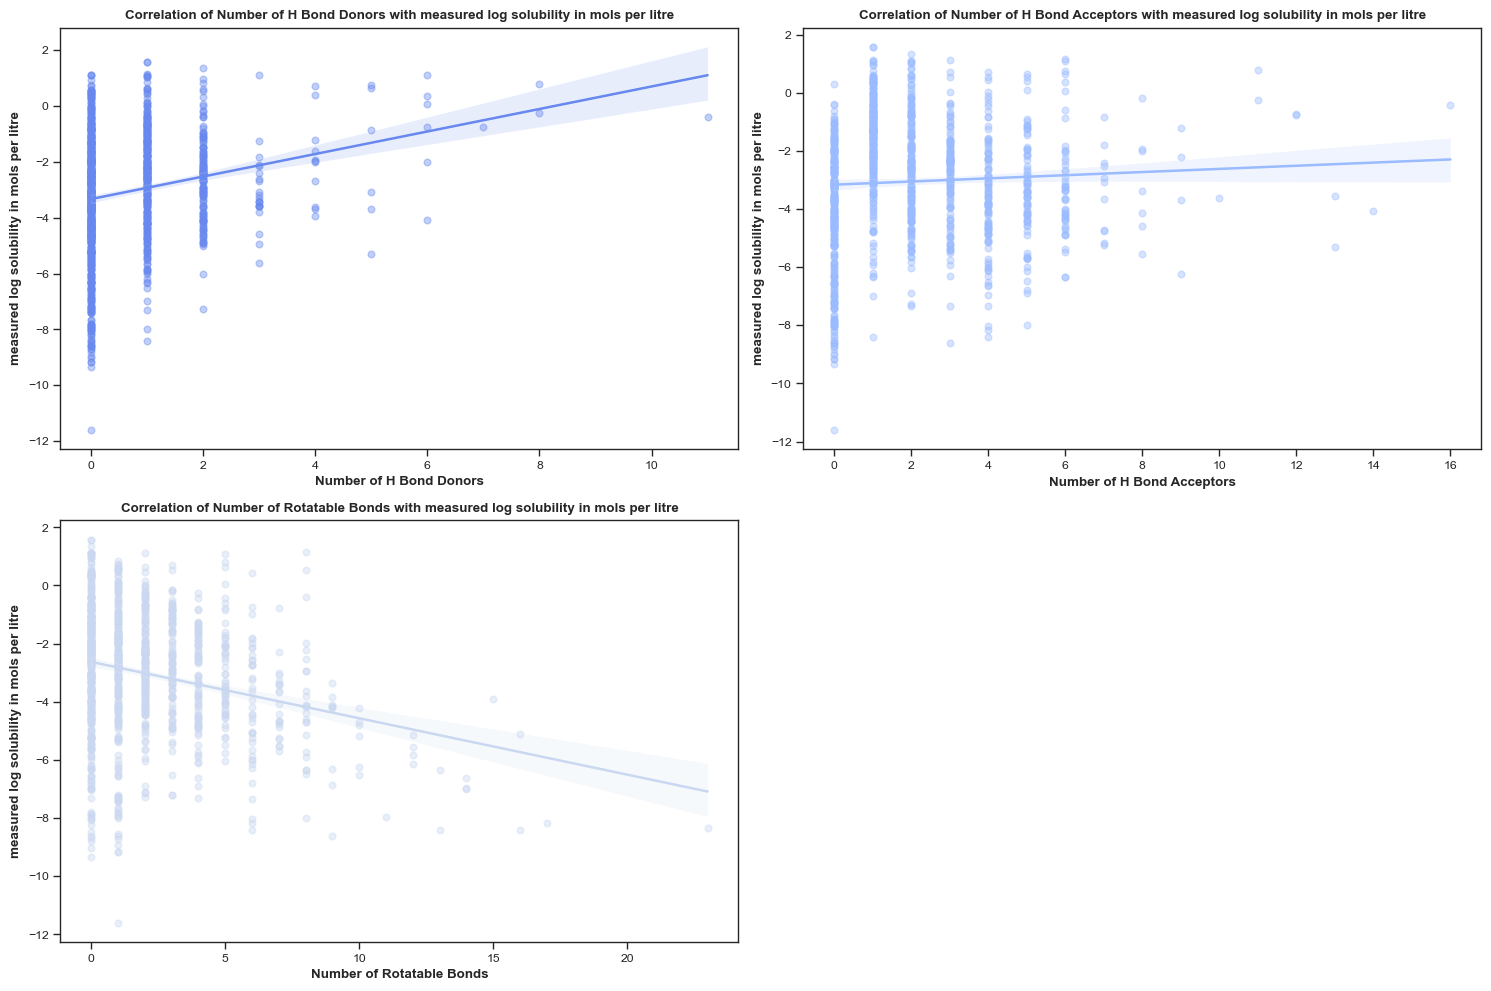

In [22]:
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

for index, feature in enumerate(non_cont_features):
    if index >= nrows * ncols:
        break  # Exit the loop if we've plotted all available subplots
    i = index // ncols
    j = index % ncols
    
    # Use the color from the palette based on the index
    color = color_palette[index % len(color_palette)]
    
    sns.regplot(x=baseline_df[feature], y=baseline_df[comparison_cont_feature], ax=axs[i, j], scatter_kws={'alpha': 0.4}, color=color)
    axs[i, j].set_title('Correlation of ' + feature + ' with ' + comparison_cont_feature, fontweight='bold')
    axs[i, j].set_ylabel(str(comparison_cont_feature), fontweight='bold')
    axs[i, j].set_xlabel(str(feature), fontweight='bold')

# Hiding any empty subplots if there are more subplots than features
for i in range(len(non_cont_features), nrows * ncols):
    axs[i // ncols, i % ncols].axis('off')

plt.tight_layout()
plt.show()

In both cases we see a slight positive correlation, though in the case of the H Bond Donors this is a stronger correlation, perhaps indicating that the donor ability of the molecule dominates in aqueous solution. As the number of rotatable bonds decrease, the measured solubility decreases (due to poorer ability to be solvated/fit many solvent molecules around the molecule).

From this we would expect that logP, Molecular Weight and ESOL predicted solubility will be the best indicators for the aqueous solubility of a molecule.

Text(0.5, 1.0, 'Correlation Heatmap')

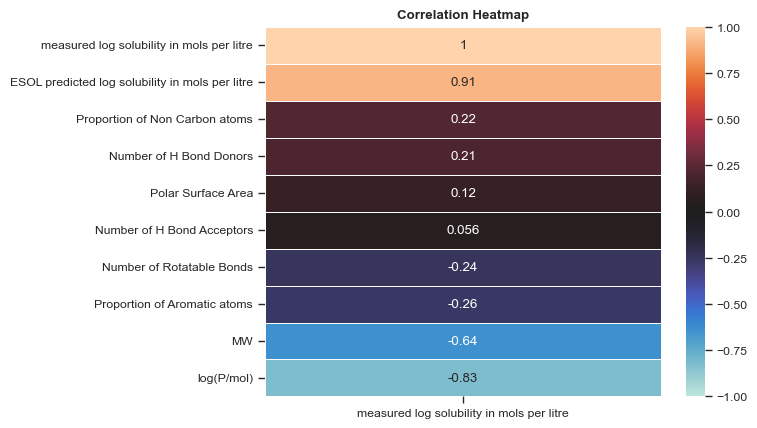

In [23]:
# Finally drawing up a correlation chart to measure the correlation between the various features and the measured solubility. 
corr = baseline_data_vis_df.corr()
ax = sns.heatmap(
    corr[['measured log solubility in mols per litre']].sort_values(by='measured log solubility in mols per litre', ascending=False), 
    vmin=-1, vmax=1, center=0,
    linewidths=0.5,
    cmap=plt.set_cmap('coolwarm'),
    annot=True,
)
ax.set_title('Correlation Heatmap', fontweight='bold')


From this it is clear that the 4 aforementioned features have the strongest correlation with the measured solubility, so we expect these to have the highest coefficients in our linear regression model. 

----
# Model Building (Delaney Model)
----
Building a linear regressor using the same features that Delaney used in his paper: _Molecular Weight_, _clogP_, _Rotatable Bonds_ and _Proportion of Aromatic Atoms_. 

In [24]:
# setting up the X and Y data. 
X = baseline_data_vis_df[['MW', 'Number of Rotatable Bonds', 'Proportion of Aromatic atoms', 'log(P/mol)']] # these are the features that we are building the model with
Y = baseline_data_vis_df['measured log solubility in mols per litre'] # this is what we are attempting to predict

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25) # we will use a test train split of 1:3

In [25]:
# bulding the model
model = LinearRegression() # a simple linear regressor.
k = 10
repeats = 100
cv = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state=1) # repeating the training 100 times, with 100 different sets of data taken from the dataset.
scores = cross_validate(model, X_train, Y_train, cv=cv, # implementing the cross validation we have created above. 
                        scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2')) # the different scoring parameters we are using

model.fit(X_train, Y_train) # fitting the data to the model
Y_pred_test = model.predict(X_test) # predicting the solubility

In [26]:
# metrics (these are R^2, mean squared erro and mean squared absolute error), we take the mean of these since we have returned 100 values. 
r2 = np.mean(scores["test_r2"])
mse = -np.mean(scores["test_neg_mean_squared_error"]) # reversing the sign since these scoring parameters are negative. 
mae = -np.mean(scores["test_neg_mean_absolute_error"])
# standard errors of metrics
r2_std_error = np.std(scores["test_r2"], ddof=1)/np.sqrt(k*repeats)
mse_std_error = np.std(scores["test_neg_mean_squared_error"], ddof=1)/np.sqrt(k*repeats)
mae_std_error = np.std(scores["test_neg_mean_absolute_error"], ddof=1)/np.sqrt(k*repeats)

print(f'R^2 value: {r2:.3f} ± {ceil(r2_std_error*1000)/1000:.3f}')
print(f'Mean squared error (MSE): {mse:.3f} ± {ceil(mse_std_error*1000)/1000:.3f}')
print(f'Mean absolute error (MAE): {mae:.3f} ± {ceil(mae_std_error*1000)/1000:.3f}')

R^2 value: 0.762 ± 0.002
Mean squared error (MSE): 1.010 ± 0.007
Mean absolute error (MAE): 0.771 ± 0.003


This is a fairly good correlation between the predicted and measured solubilities in the training. But we will compare this to another model which takes on more features a little later.

In [27]:
# storing this information for comparison later
Delaney_sklearn = { 
                    'model':'sklearn_basic_regressor',
                    'R^2':r2,
                    'MSE':mse,
                    'MAE':mae, 
                    'R^2_se': r2_std_error,                    
                    'MSE_se': mse_std_error,
                    'MAE_se': mae_std_error,
                    'intercept':model.intercept_,
                    'MW':model.coef_[0],
                    'Number of Rotatable Bonds':model.coef_[1],
                    'Proportion of Aromatic atoms':model.coef_[2],
                    'cLogP':model.coef_[3] 
                  }

----
## Model Evaluation (Delaney Model)
----

In [29]:
# now evaluating the performance of our basic model versus the ESOL predicted solubilities (these are the solubilities that Delaney himself predicted
# with his model). This is calculating the error of Delaney's predicitons and some relevant parameters.
delaney_error = baseline_data_vis_df['measured log solubility in mols per litre'] - baseline_data_vis_df['ESOL predicted log solubility in mols per litre']

corr_matrix = np.corrcoef(baseline_data_vis_df['measured log solubility in mols per litre'], baseline_data_vis_df['ESOL predicted log solubility in mols per litre'])
corr = corr_matrix[0,1]

# calculating the relevant parameters. 
delaney_r2 = corr**2 
delaney_mse = np.mean(delaney_error**2)
delaney_mae = np.mean(abs(delaney_error))


In [30]:
Delaney_reference = { 
                    'model':'ESOL',
                    'R^2':delaney_r2,
                    'MSE':delaney_mse,
                    'MAE':delaney_mae, 
                    'R^2_se': np.nan,                    
                    'MSE_se': np.nan,
                    'MAE_se': np.nan,
                    'intercept':0.16, # these values were taken  directly from Delaney's paper.
                    'MW':-0.0062,
                    'Number of Rotatable Bonds':0.066,
                    'Proportion of Aromatic atoms':-0.74,
                    'cLogP': -0.63
                    }

In [31]:
results = pd.DataFrame([Delaney_reference, Delaney_sklearn])
results = results.set_index('model')
# normalsiing the coefficients:
norm_results = results
for feature in baseline_data_vis_df.columns:
    if feature in norm_results.columns:
        norm_results[feature] = norm_results[feature] * baseline_data_vis_df[feature].mean()
norm_results

,R^2,MSE,MAE,R^2_se,MSE_se,MAE_se,intercept,MW,Number of Rotatable Bonds,Proportion of Aromatic atoms,cLogP
model,,,,,,,,,,,
ESOL,0.823128,0.828341,0.697862,NaN,NaN,NaN,0.160000,-1.264410,0.143702,-0.269022,-0.630000
sklearn_basic_regressor,0.762449,1.009505,0.770604,0.001682,0.006084,0.002155,0.205815,-1.308434,0.009996,-0.172009,-0.736836


So what does this tell us? 
It tells us that ESOL places a higher weighting on proportion of aromatic atoms and number of rotatable bonds, whereas our model places a higher weight on LogP values and molecular weight.
ESOL performs better than our model, with a higher R^2 value, and errors, perhaps tuning some of the parameters of the model would improve the performance. 

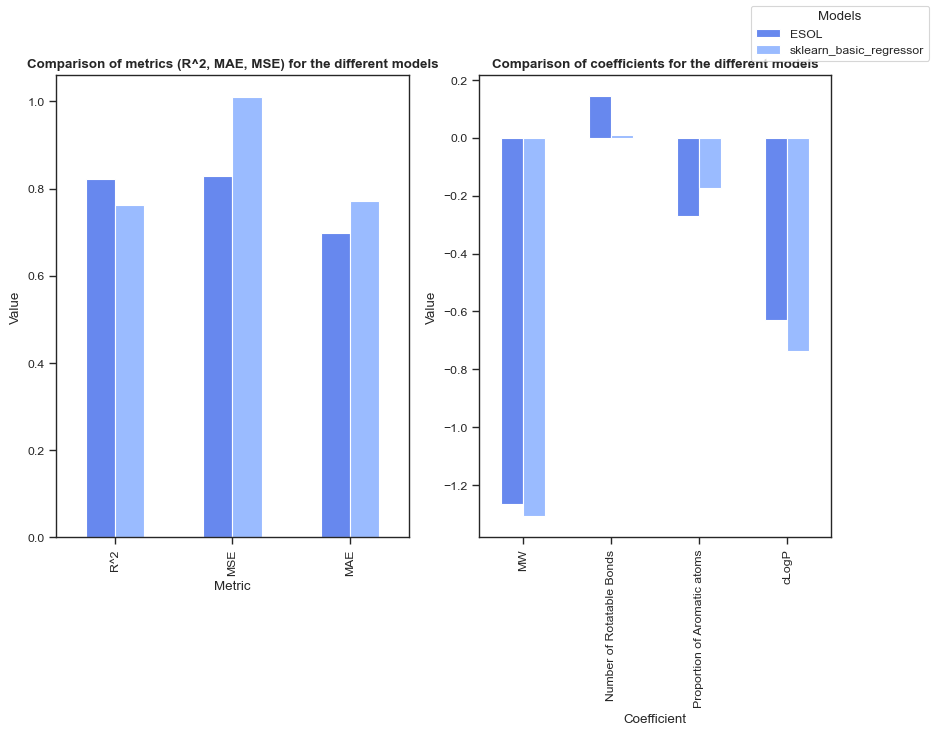

In [32]:
# finally plotting what we have discovered (the coefficient differences R^2 values, MSE and MAE values)
metrics = ['R^2', 'MSE', 'MAE']
metric_data = norm_results[metrics]
metric_data = metric_data.transpose()

# getting the coefficient data
coeffs = ['MW', 'Number of Rotatable Bonds', 'Proportion of Aromatic atoms', 'cLogP']
coeff_data = norm_results[coeffs]
coeff_data = coeff_data.transpose() # putting this into a plotable form

# plotting the figures: 
fig, axs = plt.subplots(ncols=2, figsize=(10,6))

axs[0] = metric_data.plot(kind='bar', ax=axs[0], legend=False)
# Set plot labels and title
axs[0].set_xlabel('Metric')
axs[0].set_ylabel('Value')
axs[0].set_title('Comparison of metrics (R^2, MAE, MSE) for the different models', fontweight='bold')

axs[1] = coeff_data.plot(kind='bar', ax=axs[1], legend=False)
# Set plot labels and title
axs[1].set_xlabel('Coefficient')
axs[1].set_ylabel('Value')
axs[1].set_title('Comparison of coefficients for the different models', fontweight='bold')

fig.legend(labels=norm_results.index, title='Models')

----
# Improving the model
----
We can attempt to improve the model by adding features to the linear regressor, these could include the other features already in the dataframe, and other features such as number of rings.

----
## Additional Data Collection
----

In [7]:
baseline_df = pd.read_csv('delaney-processed-baseline.csv')

# adding the number of rings to the dataframe: 
def num_of_rings(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return calc_descriptors_from_smiles(mol)['RingCount']
    
baseline_df['Number of Rings'] = baseline_df['smiles'].apply(num_of_rings)

In [8]:
baseline_data_vis_df = baseline_df.drop(['Unnamed: 0', 'Molecule', 'smiles', 'Compound ID'], axis=1)
baseline_data_vis_df

,ESOL predicted log solubility in mols per litre,measured log solubility in mols per litre,MW,log(P/mol),Number of Rotatable Bonds,Proportion of Aromatic atoms,Proportion of Non Carbon atoms,Polar Surface Area,Number of H Bond Donors,Number of H Bond Acceptors,Number of Rings
0,-0.974,-0.770,457.432,-3.10802,7,0.187500,0.375000,202.32,7,12,3
1,-2.885,-3.300,201.225,2.84032,2,0.733333,0.200000,42.24,1,2,2
2,-2.579,-2.060,152.237,2.87800,4,0.000000,0.090909,17.07,0,1,0
3,-6.618,-7.870,278.354,6.29940,0,1.000000,0.000000,0.00,0,0,5
4,-2.232,-1.330,84.143,1.74810,0,1.000000,0.200000,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1123,-2.608,-1.710,197.381,2.50850,0,0.000000,0.714286,0.00,0,0,0
1124,-0.908,0.106,219.266,0.10710,1,0.000000,0.500000,71.00,1,5,0
1125,-3.323,-3.091,246.359,2.99000,7,0.000000,0.500000,18.46,0,5,0
1126,-2.245,-3.180,72.151,2.05240,1,0.000000,0.000000,0.00,0,0,0


----
## Visualising the new feature
----

Text(0.5, 0, 'Number of Rings')

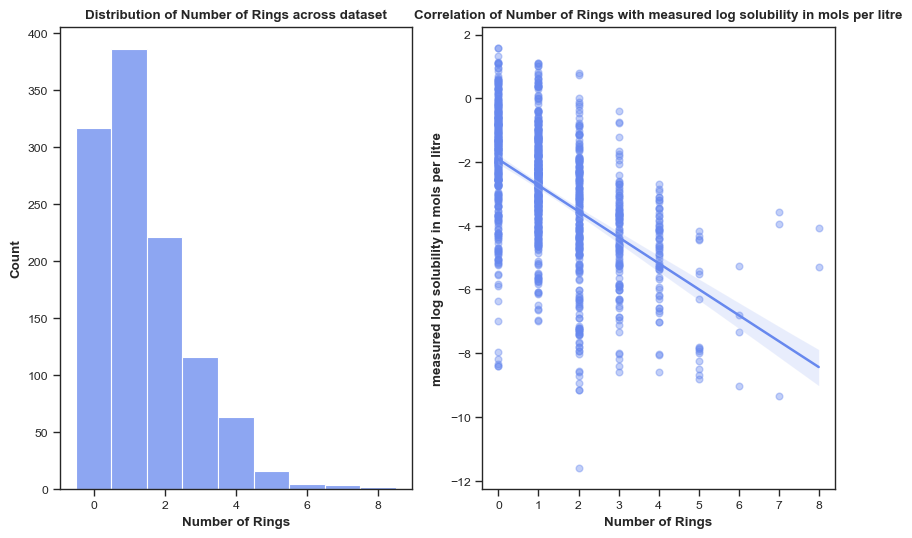

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(10,6))

feature = 'Number of Rings'
comparison_cont_feature = 'measured log solubility in mols per litre'

sns.histplot(baseline_df[feature], bins=50, discrete=True, ax=axs[0])
axs[0].set_title('Distribution of ' + feature + ' across dataset', fontweight='bold')
axs[0].set_ylabel('Count', fontweight='bold')
axs[0].set_xlabel(str(feature), fontweight='bold')

sns.regplot(x=baseline_df[feature], y=baseline_df[comparison_cont_feature], ax=axs[1], scatter_kws={'alpha': 0.4})
axs[1].set_title('Correlation of ' + feature + ' with ' + comparison_cont_feature, fontweight='bold')
axs[1].set_ylabel(str(comparison_cont_feature), fontweight='bold')
axs[1].set_xlabel(str(feature), fontweight='bold')

We can see that the number of rings is skewed towards 0, centred about 1. We can see that the measured solubility is negatively correlated with the number of rings.

----
## Building the improved model
----

In [10]:
# building an improved model which uses all of the features in the dataset
cols = list(baseline_data_vis_df.columns)
cols.remove('ESOL predicted log solubility in mols per litre')
cols.remove('measured log solubility in mols per litre')
print(cols)

X = baseline_data_vis_df[cols]
Y = baseline_data_vis_df['measured log solubility in mols per litre']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

['MW', 'log(P/mol)', 'Number of Rotatable Bonds', 'Proportion of Aromatic atoms', 'Proportion of Non Carbon atoms', 'Polar Surface Area', 'Number of H Bond Donors', 'Number of H Bond Acceptors', 'Number of Rings']


In [11]:
# bulding the model
model = LinearRegression() # a simple linear regressor.
k = 10
repeats = 100
cv = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state=1) # repeating the training 100 times, with 100 different sets of data taken from the dataset.
scores = cross_validate(model, X_train, Y_train, cv=cv, # implementing the cross validation we have created above. 
                        scoring=('neg_mean_squared_error', 'neg_mean_absolute_error', 'r2')) # the different scoring parameters we are using

model.fit(X_train, Y_train) # fitting the data to the model
Y_pred_test = model.predict(X_test) # predicting the solubility

In [12]:
# metrics (these are R^2, mean squared erro and mean squared absolute error), we take the mean of these since we have returned 100 values. 
r2 = np.mean(scores["test_r2"])
mse = -np.mean(scores["test_neg_mean_squared_error"]) # reversing the sign since these scoring parameters are negative. 
mae = -np.mean(scores["test_neg_mean_absolute_error"])
# standard errors of metrics
r2_std_error = np.std(scores["test_r2"], ddof=1)/np.sqrt(k*repeats)
mse_std_error = np.std(scores["test_neg_mean_squared_error"], ddof=1)/np.sqrt(k*repeats)
mae_std_error = np.std(scores["test_neg_mean_absolute_error"], ddof=1)/np.sqrt(k*repeats)

print(f'R^2 value: {r2:.3f} ± {ceil(r2_std_error*1000)/1000:.3f}')
print(f'Mean squared error (MSE): {mse:.3f} ± {ceil(mse_std_error*1000)/1000:.3f}')
print(f'Mean absolute error (MAE): {mae:.3f} ± {ceil(mae_std_error*1000)/1000:.3f}')

R^2 value: 0.777 ± 0.002
Mean squared error (MSE): 0.929 ± 0.005
Mean absolute error (MAE): 0.752 ± 0.002


In [14]:
# storing this information for comparison later
['MW', 'log(P/mol)', 'Number of Rotatable Bonds', 'Proportion of Aromatic atoms', 'Proportion of Non Carbon atoms',
'Polar Surface Area', 'Number of H Bond Donors', 'Number of H Bond Acceptors', 'Number of Rings']
Delaney_sklearn_improved =  { 'model':'sklearn_improved_regressor',
                              'R^2':r2,
                              'MSE':mse,
                              'MAE':mae, 
                              'R^2_se': r2_std_error,                    
                              'MSE_se': mse_std_error,
                              'MAE_se': mae_std_error,
                              'intercept':model.intercept_,
                              'MW':model.coef_[0],
                              'Number of Rotatable Bonds':model.coef_[2],
                              'Proportion of Aromatic atoms':model.coef_[3],
                              'cLogP':model.coef_[1],
                              'Proportion of Non Carbon atoms':model.coef_[4],
                              'Polar Surface Area': model.coef_[5],
                              'Number of H Bond Donors': model.coef_[6],
                              'Number of H Bond Acceptors': model.coef_[7],
                              'Number of rings': model.coef_[8],
                            }

In [33]:
results = pd.DataFrame([Delaney_reference, Delaney_sklearn, Delaney_sklearn_improved])
results = results.set_index('model')
# normalsiing the coefficients:
norm_results = results
for feature in baseline_data_vis_df.columns:
    if feature in norm_results.columns:
        norm_results[feature] = norm_results[feature] * baseline_data_vis_df[feature].mean()
norm_results

,R^2,MSE,MAE,R^2_se,MSE_se,MAE_se,intercept,MW,Number of Rotatable Bonds,Proportion of Aromatic atoms,cLogP,Proportion of Non Carbon atoms,Polar Surface Area,Number of H Bond Donors,Number of H Bond Acceptors,Number of rings
model,,,,,,,,,,,,,,,,
ESOL,0.823128,0.828341,0.697862,NaN,NaN,NaN,0.160000,-1.264410,0.143702,-0.269022,-0.630000,NaN,NaN,NaN,NaN,NaN
sklearn_basic_regressor,0.762449,1.009505,0.770604,0.001682,0.006084,0.002155,0.205815,-1.308434,0.009996,-0.172009,-0.736836,NaN,NaN,NaN,NaN,NaN
sklearn_improved_regressor,0.776892,0.928619,0.752452,0.001430,0.004850,0.001932,0.171753,-0.946517,-0.053036,-0.098428,-0.808984,0.113181,-0.456261,-0.024357,0.397244,-0.139966


So what are the key takeaways with the improved model? 
1. Well the improved model does show a slightly stronger performance (but only slightly) than the basic model, but it still performs worse than Delaney's model. Although we could probably predict this since the new features weren't strongly correlated to the measured solubility (so we wouldn't expect these features to have strong predictive power). 
1. We would also expect the number of rings to be correlated to the proportion of aromatic atoms somewhat, since we would expect that a large number of rings in these compounds are aromatic which probably also doesn't help with the predictive power of this feature.
1. As expected the best predictive features are the molecular weight and cLogP as predicted at the beginning of this analysis due to its strong correlation

In [34]:
results, names = [], []

models = {'Linear Regression': LinearRegression(),
          'Decision Tree': DecisionTreeRegressor(),
          'Random Forest': RandomForestRegressor(),
          'Gradient Boosting': GradientBoostingRegressor()}

results, names = [], []
for name, feature_selection in models.items():

    rfecv = RFECV(estimator=feature_selection) # using recursive feature elimination to remove features that are highly correlated with one another.
    rfecv.fit(X_train, Y_train)
    model = LinearRegression()
    pipe = Pipeline(steps=[('s',rfecv),('m',model)])

    cv = RepeatedKFold(n_splits=k, n_repeats=10, random_state=1)
    scores = -cross_val_score(pipe, X_train, Y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    results.append(scores)
    names.append(name)

    print(f'> model: {name}, {sum(rfecv.support_)} features, mae: {np.mean(scores):.3f} ± {np.std(scores, ddof=1)/np.sqrt(k*repeats):.3f}')

> model: Linear Regression, 4 features, mae: 0.771 ± 0.002
> model: Decision Tree, 3 features, mae: 0.777 ± 0.002
> model: Random Forest, 4 features, mae: 0.771 ± 0.002
> model: Gradient Boosting, 3 features, mae: 0.771 ± 0.002


From this we can see that the models perform similarily, and use a similar number of features, although the linear regressor uses one more than the others.